## Excercise 2 - **Data transfer optimisations (advanced, 1st part)**

The goal of this exercise is to:
- learn how to use shared memory (on-chip) to avoid main memory accesses.

Prerequisites:
- the introduction notebook *Benchmarking memory copy and establishing peak memory access performance* (`1_memorycopy.ipynb`)
- the first *Data transfer optimisation notebook* (`2_datatransfer_optimisations.ipynb`)

[*This content is distributed under MIT licence. Authors: S. Omlin (CSCS), L. Räss (ETHZ).*](https://github.com/eth-vaw-glaciology/course-101-0250-00/blob/main/LICENSE.md)

We will again use the packages `CUDA`, `BenchmarkTools` and `Plots` to create a little performance laboratory:

In [1]:
# ] activate .

In [2]:
# ] instantiate

In [3]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

#using IJulia
using CUDA
using BenchmarkTools
using Plots

  Activating project at `~/github/Learning/Courses/AdvancedCUDA/part2/solutions`
┌ Warning: CUDA runtime library `libcublasLt.so.12` was loaded from a system path, `/usr/local/cuda/lib64/libcublasLt.so.12`.
│ This may cause errors.
│ 
│ If you're running under a profiler, this situation is expected. Otherwise,
│ ensure that your library path environment variable (e.g., `PATH` on Windows
│ or `LD_LIBRARY_PATH` on Linux) does not include CUDA library paths.
│ 
│ In any other case, please file an issue.
└ @ CUDA /home/araki/.julia/packages/CUDA/1kIOw/src/initialization.jl:219
┌ Warning: CUDA runtime library `libnvJitLink.so.12` was loaded from a system path, `/usr/local/cuda/lib64/libnvJitLink.so.12`.
│ This may cause errors.
│ 
│ If you're running under a profiler, this situation is expected. Otherwise,
│ ensure that your library path environment variable (e.g., `PATH` on Windows
│ or `LD_LIBRARY_PATH` on Linux) does not include CUDA library paths.
│ 
│ In any other case, please file an 

Let us consider the same 2-D heat diffusion solver as in the second part of the first *Data transfer optimisation notebook* (`2_datatransfer_optimisations.ipynb`):

In [4]:
function diffusion2D()
    # Physics
    lam      = 1.0                                          # Thermal conductivity
    c0       = 2.0                                          # Heat capacity
    lx, ly   = 10.0, 10.0                                   # Length of computational domain in dimension x and y

    # Numerics
    nx, ny   = 32*2, 32*2                                   # Number of gridpoints in dimensions x and y
    nt       = 100                                          # Number of time steps
    dx       = lx/(nx-1)                                    # Space step in x-dimension
    dy       = ly/(ny-1)                                    # Space step in y-dimension
    _dx, _dy = 1.0/dx, 1.0/dy

    # Array initializations
    T    = CUDA.zeros(Float64, nx, ny)                      # Temperature
    T2   = CUDA.zeros(Float64, nx, ny)                      # 2nd array for Temperature
    Ci   = CUDA.zeros(Float64, nx, ny)                      # 1/Heat capacity

    # Initial conditions
    Ci .= 1/c0                                              # 1/Heat capacity (could vary in space)
    T  .= CuArray([10.0*exp(-(((ix-1)*dx-lx/2)/2)^2-(((iy-1)*dy-ly/2)/2)^2) for ix=1:size(T,1), iy=1:size(T,2)]) # Initialization of Gaussian temperature anomaly
    T2 .= T;                                                 # Assign also T2 to get correct boundary conditions.

    # Time loop
    dt  = min(dx^2,dy^2)/lam/maximum(Ci)/4.1                # Time step for 2D Heat diffusion
    opts = (aspect_ratio=1, xlims=(1, nx), ylims=(1, ny), clims=(0.0, 10.0), c=:davos, xlabel="Lx", ylabel="Ly") # plotting options
    @gif for it = 1:nt
        diffusion2D_step!(T2, T, Ci, lam, dt, _dx, _dy)     # Diffusion time step.
        heatmap(Array(T)'; opts...)
        T, T2 = T2, T                                       # Swap the aliases T and T2 (does not perform any array copy)
    end
end

function diffusion2D_step!(T2, T, Ci, lam, dt, _dx, _dy)
    threads = (32, 8)
    blocks  = (size(T2,1)÷threads[1], size(T2,2)÷threads[2])
    @cuda blocks=blocks threads=threads update_temperature!(T2, T, Ci, lam, dt, _dx, _dy)
end

function update_temperature!(T2, T, Ci, lam, dt, _dx, _dy)
    ix = (blockIdx().x-1) * blockDim().x + threadIdx().x
    iy = (blockIdx().y-1) * blockDim().y + threadIdx().y
    if (ix>1 && ix<size(T2,1) && iy>1 && iy<size(T2,2))
        @inbounds T2[ix,iy] = T[ix,iy] + dt*Ci[ix,iy]*(
                              - ((-lam*(T[ix+1,iy] - T[ix,iy])*_dx) - (-lam*(T[ix,iy] - T[ix-1,iy])*_dx))*_dx
                              - ((-lam*(T[ix,iy+1] - T[ix,iy])*_dy) - (-lam*(T[ix,iy] - T[ix,iy-1])*_dy))*_dy
                              )
    end
    return
end

update_temperature! (generic function with 1 method)

Moreover, for benchmarking activities, we will require again the following arrays and scalars (use again the `nx=ny` found best in the introduction notebook; you can modify the value if it is not right for you):

In [5]:
nx = ny = 512*32
T    = CUDA.rand(Float64, nx, ny);
T2   = CUDA.rand(Float64, nx, ny);
Ci   = CUDA.rand(Float64, nx, ny);
lam = _dx = _dy = dt = rand();

In the introduction notebook, we determined how the performance of memory copy behaved with in function of the number of threads per blocks. We will do the same now for the temperature update kernel.

### Task 1 (Performance evaluation)

Determine the effective memory throughput, `T_eff`, of the kernel `update_temperature!` in function of the number of threads, fixing the number of threads in x dimension to 32.
> 💡 Hint: you can base yourself on the corresponding activity in the introduction notebook (remember to compute now `T_eff` rather than `T_tot`).

In [6]:
# solution
max_threads  = attribute(device(),CUDA.DEVICE_ATTRIBUTE_MAX_THREADS_PER_BLOCK)
thread_count = []
throughputs  = []
for pow = 0:Int(log2(max_threads/32))
    threads = (32, 2^pow)
    blocks  = (nx÷threads[1], ny÷threads[2])
    t_it = @belapsed begin @cuda blocks=$blocks threads=$threads update_temperature!($T2, $T, $Ci, $lam, $dt, $_dx, $_dy); synchronize() end
    T_eff = (2*1+1)*1/1e9*nx*ny*sizeof(Float64)/t_it
    push!(thread_count, prod(threads))
    push!(throughputs, T_eff)
    println("(threads=$threads) T_eff = $(T_eff)")
    #IJulia.clear_output(true)
    #display(plot(thread_count, throughputs))
end

(threads=(32, 1)) T_eff = 134.18191261115888
(threads=(32, 2)) T_eff = 134.40942944875127
(threads=(32, 4)) T_eff = 134.94532225261642
(threads=(32, 8)) T_eff = 133.87668829296436
(threads=(32, 16)) T_eff = 133.7547359814004
(threads=(32, 32)) T_eff = 116.637282067214


Save the best thread/block configuration measured for reusing it later (adapt the code if your variable names above do not match):

In [7]:
T_tot_max, index = findmax(throughputs)
threads = (32, thread_count[index]÷32)
blocks  = (nx÷threads[1], ny÷threads[2])

(512, 4096)

You could probably observe that this kernel is more sensisitive to the thread/block configuration than the memory copy kernel. The reason is that the thread/block configuration directly influences the way the fast memory situated on-chip (here high-level cache and registers) is used in order to avoid redundant main memory accesses. We will now explicitly control part of the the on-chip memory usage, using so called "shared memory", which is repurposed high-level cache. This will give some insights on how certain parameters relate to on-chip memory usage. However, we will not implement a diffusion kernel with shared memory at once, but in little steps.
Let us start with relating the `update_temperature!` kernel back to the triad memory copy kernel investigated in the introduction notebook. We can observe that if we remove the derivatives from the `update_temperature!` kernel then we end up with a simple triad memory copy kernel, except for an additional if-statement to avoid updating the boundary values (for simplicity, we do not remove the unused function arguments which we will use again in the next experiments):

In [8]:
function update_temperature!(T2, T, Ci, lam, dt, _dx, _dy)
    ix = (blockIdx().x-1) * blockDim().x + threadIdx().x
    iy = (blockIdx().y-1) * blockDim().y + threadIdx().y
    if (ix>1 && ix<size(T2,1) && iy>1 && iy<size(T2,2))
        @inbounds T2[ix,iy] = T[ix,iy] + dt*Ci[ix,iy]
    end
    return
end

update_temperature! (generic function with 1 method)

This kernel should consequently achieve a `T_tot` of essentially the value of `T_peak` (if an optimal thread/block configuration is used). Moreover, for this case `T_eff = T_tot`. Let us verify quickly that `T_eff` is essentially equal `T_peak` here (measured 561 GB/s with the Tesla P100 GPU):

In [9]:
t_it = @belapsed begin @cuda blocks=$blocks threads=$threads update_temperature!($T2, $T, $Ci, $lam, $dt, $_dx, $_dy); synchronize() end
T_eff = (2*1+1)*1/1e9*nx*ny*sizeof(Float64)/t_it

207.8612428122374

We will do now our first shared memory experiment with this simple triad kernel.

### Task 2 (Shared memory basics)

Modify the above `update_temperature!` kernel (which now does just triad memory copy) as follows: read the values of the temperature array `T` into shared memory; then, subsequently, read the temperature values from there when updating `T2`.
To help you, the structure of the kernel is already given; you only need to complete the unfinished lines.
> 💡 Hint: use [CuDynamicSharedArray](https://cuda.juliagpu.org/stable/api/kernel/#CUDA.CuDynamicSharedArray) to allocate the required shared memory
>
> 💡 Hint: shared memory is block-local, i.e. shared between the threads of a same block.
>
> 💡 Note that shared memory as well as registers are a very limited resource and the amount a kernel needs increases normally with the number of threads launched per block. As a result, the mamximum number of threads launchable per block can be restricted by the needed on-chip resources to a value less than the general limit of the device (attribute `CUDA.DEVICE_ATTRIBUTE_MAX_THREADS_PER_BLOCK`). The CUDA occupancy API lets query the maximum number of threads possible for a given kernel (see [maxthreads](https://cuda.juliagpu.org/stable/api/compiler/#CUDA.maxthreads)).

In [10]:
# solution
function update_temperature!(T2, T, Ci, lam, dt, _dx, _dy)
    ix = (blockIdx().x-1) * blockDim().x + threadIdx().x
    iy = (blockIdx().y-1) * blockDim().y + threadIdx().y
    tx = threadIdx().x
    ty = threadIdx().y
    T_l = CuDynamicSharedArray(eltype(T), (blockDim().x, blockDim().y))
    @inbounds T_l[tx,ty] = T[ix,iy]
    if (ix>1 && ix<size(T2,1) && iy>1 && iy<size(T2,2))
        @inbounds T2[ix,iy] = T_l[tx,ty] + dt*Ci[ix,iy]
    end
    return
end

update_temperature! (generic function with 1 method)

### Task 3 (Shared memory basics)

Launch the kernel requesting the required amount of shared memory; compute the `T_eff` achieved.
> 💡 Hint: the `@cuda` macro supports the keyword `shmem` to request the required amount of shared memory; note that it must be indicated in bytes (use sizeof() to get the number of bytes used by the datatype used).

In [11]:
# solution
t_it = @belapsed begin @cuda blocks=$blocks threads=$threads shmem=prod($threads)*sizeof(Float64) update_temperature!($T2, $T, $Ci, $lam, $dt, $_dx, $_dy); synchronize() end
T_eff = (2*1+1)*1/1e9*nx*ny*sizeof(Float64)/t_it

207.9376377930188

You should not observe any significant change in `T_eff` compared to the previous kernel (measured as before 561 GB/s with the Tesla P100 GPU).
When we will add back the derivatives later, then each thread will read values on the left, right, bottom and top of it. We will want the threads to read the temperature values from the block-local array `T_l`, not from `T` anymore. However, right now each thread maps directly to a cell of `T_l`; thus, the threads at the boundary of the block would read out-of-bounds when reading the "neighbour cells". We therefore need to add a "halo" to `T_l` that will contain the required values.

### Task 4 (Shared memory)

Modify the `update_temperature!` kernel from Task 2 as follows: add a "halo" of size `1` to `T_l` on each side, i.e. on the left, right, bottom and top. To this purpose, you need to modify the allocation of `T_l` and adapt the local thread ids `tx` and `ty` accordingly. Then, launch the new kernel adjusting the required amount of shared memory and compute `T_eff`.
To help you, the structure of the kernel is already given; you only need to complete the unfinished lines.

In [12]:
# solution
function update_temperature!(T2, T, Ci, lam, dt, _dx, _dy)
    ix = (blockIdx().x-1) * blockDim().x + threadIdx().x
    iy = (blockIdx().y-1) * blockDim().y + threadIdx().y
    tx = threadIdx().x+1
    ty = threadIdx().y+1
    T_l = CuDynamicSharedArray(eltype(T), (blockDim().x+2, blockDim().y+2))
    @inbounds T_l[tx,ty] = T[ix,iy]
    if (ix>1 && ix<size(T2,1) && iy>1 && iy<size(T2,2))
        @inbounds T2[ix,iy] = T_l[tx,ty] + dt*Ci[ix,iy]
    end
    return
end

t_it = @belapsed begin @cuda blocks=$blocks threads=$threads shmem=prod($threads.+2)*sizeof(Float64) update_temperature!($T2, $T, $Ci, $lam, $dt, $_dx, $_dy); synchronize() end
T_eff = (2*1+1)*1/1e9*nx*ny*sizeof(Float64)/t_it

207.92836300989353

`T_eff` did certainly not significantly change, as you probably expected as we did not access more data than before (measured as before 561 GB/s with the Tesla P100 GPU).

### Task 5 (Shared memory)

Modify the `update_temperature!` kernel from Task 4 as follows: read the required values into the newly added halo of `T_l`. Then, compute again `T_eff`.
To help you, the structure of the kernel is already given; you only need to complete the unfinished lines.

In [13]:
# solution
function update_temperature!(T2, T, Ci, lam, dt, _dx, _dy)
    ix = (blockIdx().x-1) * blockDim().x + threadIdx().x
    iy = (blockIdx().y-1) * blockDim().y + threadIdx().y
    tx = threadIdx().x+1
    ty = threadIdx().y+1
    T_l = CuDynamicSharedArray(eltype(T), (blockDim().x+2, blockDim().y+2))
    @inbounds T_l[tx,ty] = T[ix,iy]
    if (ix>1 && ix<size(T2,1) && iy>1 && iy<size(T2,2))
        @inbounds if (threadIdx().x == 1)            T_l[tx-1,ty] = T[ix-1,iy] end
        @inbounds if (threadIdx().x == blockDim().x) T_l[tx+1,ty] = T[ix+1,iy] end
        @inbounds if (threadIdx().y == 1)            T_l[tx,ty-1] = T[ix,iy-1] end
        @inbounds if (threadIdx().y == blockDim().y) T_l[tx,ty+1] = T[ix,iy+1] end
        @inbounds T2[ix,iy] = T_l[tx,ty] + dt*Ci[ix,iy]
    end
    return
end

t_it = @belapsed begin @cuda blocks=$blocks threads=$threads shmem=prod($threads.+2)*sizeof(Float64) update_temperature!($T2, $T, $Ci, $lam, $dt, $_dx, $_dy); synchronize() end
T_eff = (2*1+1)*1/1e9*nx*ny*sizeof(Float64)/t_it

207.89698118699513

`T_eff` certainly decreased a bit due to the additional read-in of the halo of `T_l` (measured 538 GB/s with the Tesla P100 GPU), except if the compiler would have understood that the halo is never used and therefore never done these additional reads. In order to create the 2-D diffusion kernel using shared memory, the last step is to add back the derivatives.

### Task 6 (Shared memory)

Modify the `update_temperature!` kernel from Task 5 as follows: add back the derivatives that we removed at the beginning of the notebook and modify them to read the temperature from `T_l` rather then from `T`. Then, verify that the diffusion works as expected and compute again `T_eff`.
To help you, the structure of the kernel is already given; you only need to complete the unfinished lines.

┌ Info: Saved animation to /tmp/jl_4ha3MPKtmR.gif
└ @ Plots /home/araki/.julia/packages/Plots/Ec1L1/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_4ha3MPKtmR.gif")
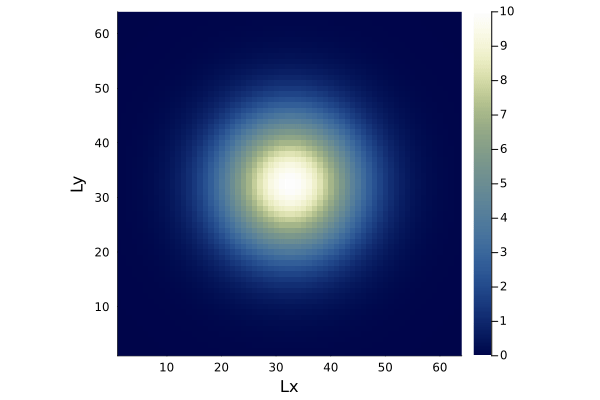

In [14]:
# solution
function update_temperature!(T2, T, Ci, lam, dt, _dx, _dy)
    ix = (blockIdx().x-1) * blockDim().x + threadIdx().x
    iy = (blockIdx().y-1) * blockDim().y + threadIdx().y
    tx = threadIdx().x+1
    ty = threadIdx().y+1
    T_l = CuDynamicSharedArray(eltype(T), (blockDim().x+2, blockDim().y+2))
    @inbounds T_l[tx,ty] = T[ix,iy]
    if (ix>1 && ix<size(T2,1) && iy>1 && iy<size(T2,2))
        @inbounds if (threadIdx().x == 1)            T_l[tx-1,ty] = T[ix-1,iy] end
        @inbounds if (threadIdx().x == blockDim().x) T_l[tx+1,ty] = T[ix+1,iy] end
        @inbounds if (threadIdx().y == 1)            T_l[tx,ty-1] = T[ix,iy-1] end
        @inbounds if (threadIdx().y == blockDim().y) T_l[tx,ty+1] = T[ix,iy+1] end
        sync_threads()
        @inbounds T2[ix,iy] = T_l[tx,ty] + dt*Ci[ix,iy]*(
                    - ((-lam*(T_l[tx+1,ty] - T_l[tx,ty])*_dx) - (-lam*(T_l[tx,ty] - T_l[tx-1,ty])*_dx))*_dx
                    - ((-lam*(T_l[tx,ty+1] - T_l[tx,ty])*_dy) - (-lam*(T_l[tx,ty] - T_l[tx,ty-1])*_dy))*_dy
                    )
    end
    return
end

function diffusion2D_step!(T2, T, Ci, lam, dt, _dx, _dy)
    threads = (32, 8)
    blocks  = (size(T2,1)÷threads[1], size(T2,2)÷threads[2])
    @cuda blocks=blocks threads=threads shmem=prod(threads.+2)*sizeof(Float64) update_temperature!(T2, T, Ci, lam, dt, _dx, _dy); synchronize()
end

diffusion2D()

In [15]:
t_it = @belapsed begin @cuda blocks=$blocks threads=$threads shmem=prod($threads.+2)*sizeof(Float64) update_temperature!($T2, $T, $Ci, $lam, $dt, $_dx, $_dy); synchronize() end
T_eff = (2*1+1)*1/1e9*nx*ny*sizeof(Float64)/t_it

133.48631753272892

> 💡 Note that the we have added a call to `sync_threads()` at the end of all reads into shared memory (i.e. `T_l`) in order to ensure that no thread tries to read a from a "neighboring cell" before it contains the required value.

※A2000 Adaでは208->133にかなり落ちた

`T_eff` should not have decreased significantly when adding back the derivatives (measured, as in Task 5, 538 GB/s with the Tesla P100 GPU) even though they constitute the major part of the computations! This confirms one more time empirically that the performance of solvers as the above is essentially defined by how much we can avoid redundant main memory accesses.

### Task 7 (Performance evaluation)

Compute by how much percent you can improve the performance of the solver at most.

In [17]:
# solution
T_peak = 224 # Peak memory throughput of the A2000 Ada GPU
T_eff/T_peak

0.5959210604139684

※ `2_datatransfer_optimisations.ipynb`の最後に計算した理論値との比較は
T_eff_Task5 / T_peak = 0.594915375837081
だったのでほとんど変わっていない...

Congratulations! You have implemented a 2-D diffusion solver using shared memory!

This completes the second part on data transfer optimisations with Julia. Note that the high-level Julia package [ParallelStencil.jl](https://github.com/omlins/ParallelStencil.jl) also allows to explicitly control shared memory. For example, the `update_temperature!` kernel can be written explicitly using shared memory and in an architecture-agnostic fashion (the code runs on different GPU and CPU architectures) as follows:

```julia
@parallel_indices (ix,iy) function diffusion2D_step!(T2, T, Ci, lam, dt, _dx, _dy)
    tx  = @threadIdx().x + 1
    ty  = @threadIdx().y + 1
    T_l = @sharedMem(eltype(T), (@blockDim().x+2, @blockDim().y+2))
    T_l[tx,ty] = T[ix,iy]
    if (ix>1 && ix<size(T2,1) && iy>1 && iy<size(T2,2))
        if (@threadIdx().x == 1)             T_l[tx-1,ty] = T[ix-1,iy] end
        if (@threadIdx().x == @blockDim().x) T_l[tx+1,ty] = T[ix+1,iy] end
        if (@threadIdx().y == 1)             T_l[tx,ty-1] = T[ix,iy-1] end
        if (@threadIdx().y == @blockDim().y) T_l[tx,ty+1] = T[ix,iy+1] end
        @sync_threads()
        T2[ix,iy] = T_l[tx,ty] + dt*(Ci[ix,iy]*(
                    - ((-lam*(T_l[tx+1,ty] - T_l[tx,ty])*_dx) - (-lam*(T_l[tx,ty] - T_l[tx-1,ty])*_dx))*_dx
                    - ((-lam*(T_l[tx,ty+1] - T_l[tx,ty])*_dy) - (-lam*(T_l[tx,ty] - T_l[tx,ty-1])*_dy))*_dy
                    ));
    end
    return
end
```